In [1]:
import os, sys
import numpy as np
import json
from addict import Dict
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
from baobab.configs import *
from h0rton.configs import TrainValConfig, TestConfig
from baobab.data_augmentation.noise_lenstronomy import NoiseModelNumpy

import glob
import matplotlib.image as mpimg
%matplotlib inline
%load_ext autoreload
%autoreload 2
# Plotting params
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

In [2]:
baobab_cfg = BaobabConfig.from_file('/home/jwp/stage/sl/h0rton/baobab_configs/v7/test_v7_baobab_config.py')
meta = pd.read_csv(os.path.abspath(os.path.join(baobab_cfg.out_dir, 'metadata.csv')), index_col=None)

img_files = [fname for fname in os.listdir(baobab_cfg.out_dir) if fname.endswith('.npy')]

In [5]:
default_version_id = 2 #12
default_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(default_version_id)
test_cfg_path = os.path.join(default_version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
noise_kwargs_default = train_val_cfg.data.noise_kwargs.copy()

In [6]:
summary = pd.read_csv(os.path.join(default_version_dir, 'summary.csv'), index_col=False, nrows=200)
metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=False)
metadata['id'] = metadata.index

In [7]:
summary.columns, summary.shape, metadata.shape

(Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
        'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std'],
       dtype='object'), (200, 12), (512, 41))

In [8]:
summary = summary.merge(metadata, on='id', suffixes=['', '_meta'], how='inner')

# 1. Gallery of test-set examples

## Get the total flux of the lensed ring

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.util as util
import lenstronomy.Util.data_util as data_util

from baobab.sim_utils import Imager, Selection, get_PSF_model
from baobab.sim_utils import flux_utils, metadata_utils
from baobab.configs import BaobabConfig

In [10]:
summary['lensed_E_ring_flux'] = 0.0
summary['lensed_E_ring_mag'] = 0.0
#summary.drop([200], inplace=True)

In [21]:
lens_mass_model = LensModel(lens_model_list=['PEMD', 'SHEAR_GAMMA_PSI'])
src_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
lens_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
components = ['lens_mass', 'src_light', 'agn_light', 'lens_light']
bp = baobab_cfg.survey_info.bandpass_list[0] # only one bandpass
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs = survey_object.kwargs_single_band()
# Factor of effective exptime relative to exptime of the noiseless images
exposure_time_factor = np.ones([1, 1, 1]) 
exposure_time_factor[0, :, :] = train_val_cfg.data.eff_exposure_time[bp]/noise_kwargs['exposure_time']

noise_kwargs.update(exposure_time=train_val_cfg.data.eff_exposure_time[bp])
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs)

for lens_i in range(200):
    imager = Imager(components, lens_mass_model, src_light_model, lens_light_model=lens_light_model, ps_model=ps_model, kwargs_numerics={'supersampling_factor': 1}, min_magnification=0.0, for_cosmography=True)
    imager._set_sim_api(num_pix=64, kwargs_detector=noise_kwargs, psf_kernel_size=survey_object.psf_kernel_size, which_psf_maps=survey_object.which_psf_maps)
    imager.kwargs_src_light = [metadata_utils.get_kwargs_src_light(metadata.iloc[lens_i])]
    imager.kwargs_src_light = flux_utils.mag_to_amp_extended(imager.kwargs_src_light, imager.src_light_model, imager.data_api)
    imager.kwargs_lens_mass = metadata_utils.get_kwargs_lens_mass(metadata.iloc[lens_i])
    sample_ps = metadata_utils.get_nested_ps(metadata.iloc[lens_i])
    imager.for_cosmography = False
    imager._load_agn_light_kwargs(sample_ps)
    lensed_total_flux, lensed_src_img = flux_utils.get_lensed_total_flux(imager.kwargs_lens_mass, imager.kwargs_src_light, None, imager.image_model, return_image=True)
    lensed_ring_total_flux = np.sum(lensed_src_img)
    summary.loc[lens_i, 'lensed_E_ring_flux'] = lensed_ring_total_flux
    summary.loc[lens_i, 'lensed_E_ring_mag'] = data_util.cps2magnitude(lensed_ring_total_flux, noise_kwargs['magnitude_zero_point'])

## Bin the Einstein ring brightness

In [22]:
print((summary['lensed_E_ring_mag'].max() - summary['lensed_E_ring_mag'].min()) / 4)
print((20.5 - 17)/4)


1.321711704310422
0.875


In [23]:
lensed_ring_bins = np.array([np.quantile(summary['lensed_E_ring_mag'].values, 0.25), np.quantile(summary['lensed_E_ring_mag'].values, 0.5), np.quantile(summary['lensed_E_ring_mag'].values, 0.75), summary['lensed_E_ring_mag'].max() + 0.1]) 
print(np.digitize([17.5, 18.5, 19.5, 20.5], lensed_ring_bins)[:5])
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

[0 0 1 2]


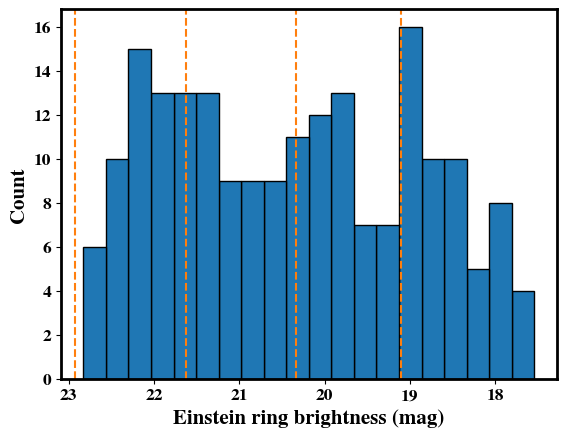

In [24]:
plt.close('all')
plt.hist(summary['lensed_E_ring_mag'], edgecolor='k', bins=20)
plt.gca().invert_xaxis()
for bin_edge in lensed_ring_bins:
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein ring brightness (mag)')
plt.ylabel('Count')
plt.show()

## Divide into quartiles of H0 uncertainty

In [9]:
summary = summary.sort_values(by='H0_std').reset_index(drop=True)
#summary.head()

summary['H0_std_quantile'] = -1

In [10]:
H0_std_bins = np.array([np.quantile(summary['H0_std'].values, 0.25), np.quantile(summary['H0_std'].values, 0.5), np.quantile(summary['H0_std'].values, 0.75), np.quantile(summary['H0_std'].values, 1) + 1]) 
print(H0_std_bins)
print(summary['H0_std'].values.max())
print(summary['H0_std'].values.min())

[ 5.72164125  6.56901996  7.55094157 11.69930859]
10.699308587834727
3.0583890599559584


In [11]:
#print(np.digitize([17.5, 18.5, 19.5, 20.5], lensed_ring_bins)[:5])
summary['H0_std_bin'] = np.digitize(summary['H0_std'].values, H0_std_bins)

In [12]:
print(np.unique(summary['H0_std_bin'].values, return_counts=True))

(array([0, 1, 2, 3]), array([50, 50, 50, 50]))


In [13]:
gallery_lens_idx = np.zeros((4, 4))
for ering_b in range(4):
    for std_b in range(4):
        chosen_i = summary[(summary['H0_std_bin']==std_b) & (summary['lensed_ring_bin']==ering_b)].iloc[0]['id']
        gallery_lens_idx[ering_b, std_b] = chosen_i
gallery_lens_idx = gallery_lens_idx.astype(int)

KeyError: 'lensed_ring_bin'

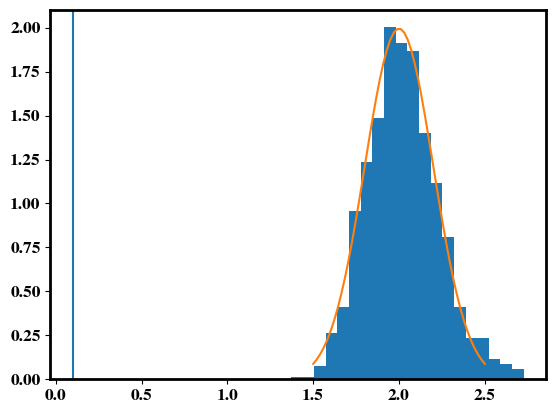

In [24]:
plt.close('all')
from scipy.stats import norm
X = np.random.normal(0.7, 0.1, size=1000)
plt.hist(np.exp(X), bins=20, density=True)
x_grid = np.linspace(1.5, 2.5, 50)
plt.plot(x_grid, norm.pdf(x_grid, loc=2, scale=0.2))
plt.axvline(0.1)
plt.show()

In [25]:
import matplotlib.pyplot as plt
img = np.load(os.path.join(cfg.out_dir, 'X_{0:07d}.npy'.format(2)))
print(np.min(img))
img = np.arcsinh(img)
img = (img - np.mean(img))/np.std(img)
plt.imshow(np.squeeze(img))
plt.colorbar()
plt.show()

NameError: name 'cfg' is not defined

In [26]:
plt.close('all')
fig, axes = plt.subplots(len(lensed_ring_bins), len(H0_std_bins), figsize=(20, 20))
for ering_b in range(4):
    for std_b in range(4):
        lens_i = gallery_lens_idx[ering_b, std_b]
        img_path = os.path.join(cfg.out_dir, 'X_{0:07d}.npy'.format(lens_i))
        img = np.load(img_path)
        noise_kwargs_default.update(exposure_time=5400*0.5)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        img += noise_model.get_noise_map(img)
        img = np.log1p(img)
        #img = (img - img.mean())/img.std()
        axes[[0, 1, 2, 3][ering_b], [3, 2, 1, 0][std_b]].imshow(img, vmin=np.min(img), vmax=np.max(img), origin='lower', cmap='viridis')
        axes[[0, 1, 2, 3][ering_b], [3, 2, 1, 0][std_b]].axis('off')

fig.tight_layout()
fig.text(0.5, -0.04, r'$H_0$ precision $\rightarrow$', ha='center', fontsize=40)
fig.text(-0.04, 0.5, r'Einstein ring brightness $\rightarrow$', va='center', rotation='vertical', fontsize=40)
#
plt.show()

NameError: name 'lensed_ring_bins' is not defined

In [ ]:
lensed_ring_bins, H0_std_bins

In [ ]:
plt.close('all')
plt.hist2d(summary['H0_std'].values, summary['lensed_E_ring_mag'].values, bins=[[0, 1.99, 2.13, 2.42, 12.36], [17, 18, 19, 20, 21]])
plt.colorbar()
plt.show()

# Visualize training set images

In [27]:

from astropy.visualization import (MinMaxInterval, AsinhStretch, SqrtStretch, LinearStretch,
                                   ImageNormalize)


In [28]:
n_test = 200
prec_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(0)
prec_summary = pd.read_csv(os.path.join(prec_version_dir, 'ering_summary.csv'), index_col=None, nrows=n_test)
summary['lensed_E_ring_mag'] = prec_summary['lensed_E_ring_mag'].values
lensed_ring_bins = np.quantile(summary['lensed_E_ring_mag'].values, [0.25, 0.5, 0.75, 1])
lensed_ring_bins[-1] += 0.1 # buffer 
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

In [129]:
summary[['id', 'lensed_E_ring_mag', 'lensed_ring_bin', 'n_img']].values

array([[  0.        ,  20.63680769,   2.        ,   4.        ],
       [  1.        ,  21.24103543,   2.        ,   2.        ],
       [  2.        ,  18.10822915,   0.        ,   2.        ],
       [  3.        ,  19.60115265,   1.        ,   2.        ],
       [  4.        ,  18.08806068,   0.        ,   2.        ],
       [  5.        ,  22.05906044,   3.        ,   2.        ],
       [  6.        ,  19.12585453,   1.        ,   2.        ],
       [  7.        ,  21.79764234,   3.        ,   2.        ],
       [  8.        ,  19.70387712,   1.        ,   2.        ],
       [  9.        ,  20.12912854,   1.        ,   4.        ],
       [ 10.        ,  21.48445947,   2.        ,   4.        ],
       [ 11.        ,  21.56667368,   2.        ,   2.        ],
       [ 12.        ,  22.83012596,   3.        ,   2.        ],
       [ 13.        ,  18.19059902,   0.        ,   4.        ],
       [ 14.        ,  22.34219205,   3.        ,   4.        ],
       [ 15.        ,  22

{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
10800.0
0.0005821499810265158 3.264365702690871
0.003942346321972793 11.369464502520366
-0.00034169094653140834 11.655043097447345
0.0004888610769103645 49.11611999005607
0.004917913190984729 13.205990922308064
-0.0021701909786089333 33.661434558153566
0.005356078418751471 13.395505397840259
0.005677570301434531 23.895716038179856
0.005082279196363565 6.551985846105201
0.010817093289395341 22.68929104575367
0.005763532738128498 23.295791539758994
0.00485238983499213 98.2498718248793
0.014883317172523084 26.29525045892313
0.003266984814978685 67.30413383404627
0.009578882683117095 26.83081720490683
0.021315787506792336 47.699156386376714
0.011666718632030046 13.010625524617511
0.030068842667631594 45.46262787427402
0.012745064021549776 46.76748765943029
0.011113523916908107 196.51141419013797
0.

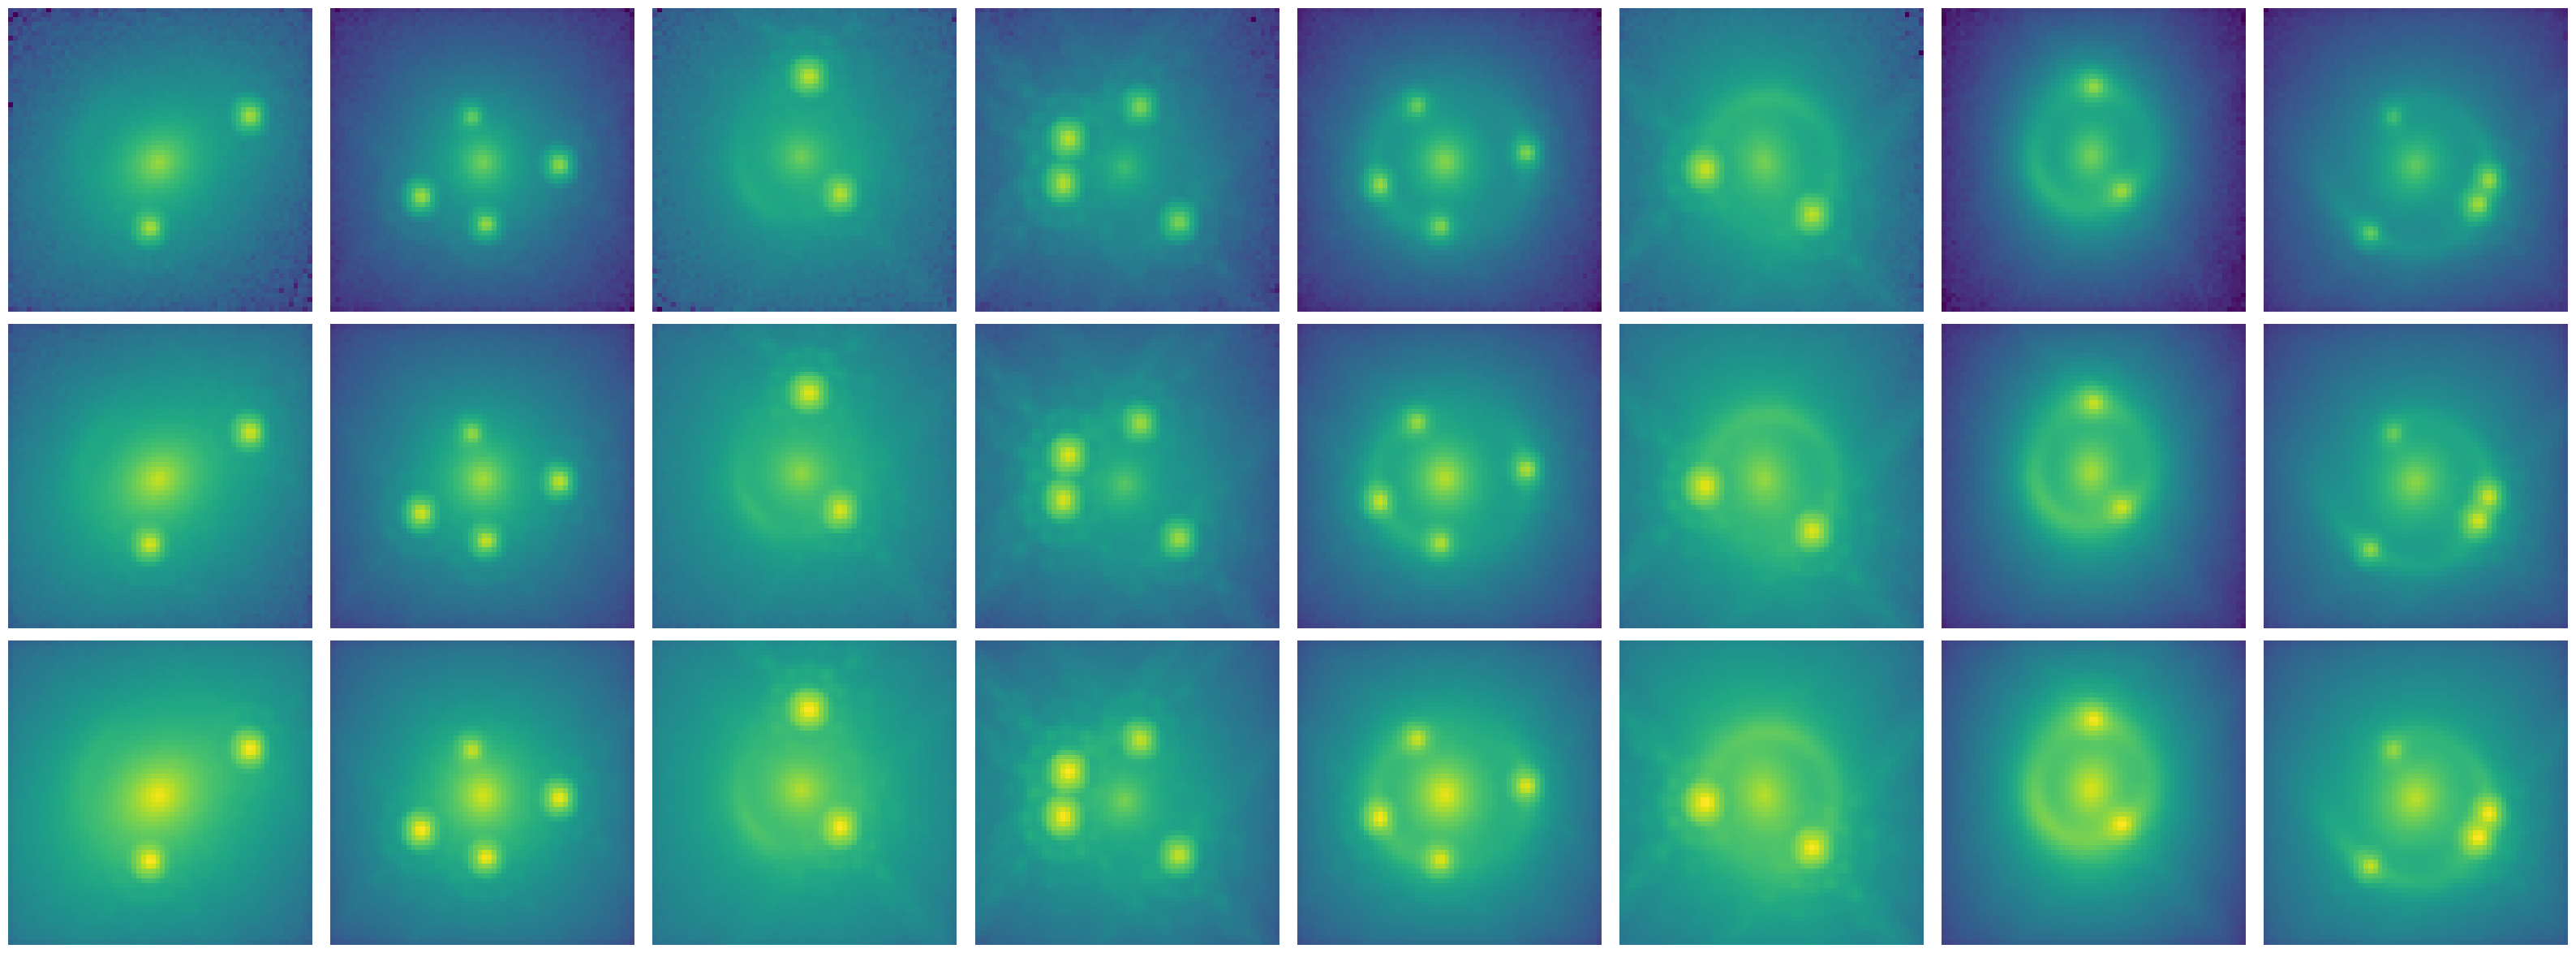

In [148]:
n_rows = 3
n_cols = 8
n_img = n_rows*n_cols

plt.close('all')
#imgs = []
#for img_file in img_files[:n_img]:
#    img_path = os.path.join(baobab_cfg.out_dir, img_file)
#    imgs.append(np.load(img_path))

fig = plt.figure(figsize=(32, 12))
imgs_per_row = n_img//n_rows
#imgs = imgs[:imgs_per_row]*4
ax = []

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = 1#np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
print(noise_kwargs_default)
# Factor of effective exptime relative to exptime of the noiseless images
print(train_val_cfg.data.eff_exposure_time[bp])
noise_kwargs_default.update(exposure_time=5400.0)
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs_default)

orig_img_ids = [181, 4, 39, 199, 58, 56, 186, 184][::-1]
#orig_img_ids = [43, 4]
distinct_lenses = len(orig_img_ids)
#img_ids = orig_img_ids*4

img_dict = {} # will be populated as a nested dict, img[img_id][exp_factor]
for i, img_id in enumerate(orig_img_ids):
    img_dict[img_id] = {}
    for exp_i, exp_factor in enumerate([0.5, 1.0, 2.0]):
        noise_kwargs_default.update(exposure_time=5400*exp_factor)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        img = np.load(os.path.join(baobab_cfg.out_dir, 'X_{0:07d}.npy'.format(img_id)))
        img *= exp_factor
        noise_map = noise_model.get_noise_map(img)
        img += noise_map
        img_dict[img_id][exp_factor] = img

vmin_dict = {}
vmax_dict = {}
for i, img_id in enumerate(orig_img_ids):
    # Get the min/max pixel value in images across exposure times
    min_pixel_vals = [np.min(lens_image[lens_image > 0]) for lens_image in [img_dict[img_id][exp_factor] for exp_factor in [0.5, 1.0, 2.0]]]
    max_pixel_vals = [np.max(lens_image) for lens_image in [img_dict[img_id][exp_factor] for exp_factor in [0.5, 1.0, 2.0]]]
    vmin_dict[img_id] = min(min_pixel_vals) #max(min(min_pixel_vals), 1.e-4)
    vmax_dict[img_id] = max(max_pixel_vals)
    
for i in range(n_cols*n_rows):
    #plt.subplot(n_rows, n_cols, i+1)
    #print(img_id, i // n_cols, noise_map[0, :5, 0])
    img_id = orig_img_ids[i%n_cols]
    exp_factor = [0.5, 1.0, 2.0][i//n_cols]
    
    #img = np.log1p(img)
    #print(np.min(img), np.max(img))
    #img = (img - np.min(img))/(np.max(img) - np.min(img))#img = (img - img.mean())/img.std()
    #img = np.log(img)
    #img = (img - np.mean(img))/np.std(img)
    img = img_dict[img_id][exp_factor]
    img = np.squeeze(img)
    print(np.min(img), np.max(img))
    
    # create subplot and append to ax
    fig.add_subplot(n_rows, n_cols, i+1)
    #print(exposure_time_factor[0, 0, 0], np.min(img), np.max(img))
    #plt.imshow(img, origin='lower', vmin=0, vmax=5, cmap='viridis', norm=None)
    img[img < 0] = vmin_dict[img_id]
    plt.imshow(img, origin='lower', norm=LogNorm(), vmin=vmin_dict[img_id], vmax=vmax_dict[img_id], cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.savefig('../training_set_gallery_fully_transformed.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

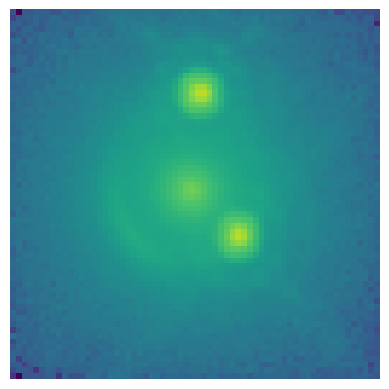

In [210]:
from matplotlib.colors import LogNorm
plt.close('all')
fig1 = plt.gcf()
diagram_img = img_dict[56][0.5].squeeze()
diagram_img[diagram_img < 0] = vmin_dict[56]
plt.imshow(diagram_img, cmap='viridis', norm=LogNorm(), vmin=vmin_dict[56], vmax=vmax_dict[56], origin='lower')
#plt.colorbar()
plt.axis('off')
plt.show()
plt.draw()
fig1.savefig('../lens_56_for_diagram.png', bbox_inches = 'tight',
    pad_inches = 0)

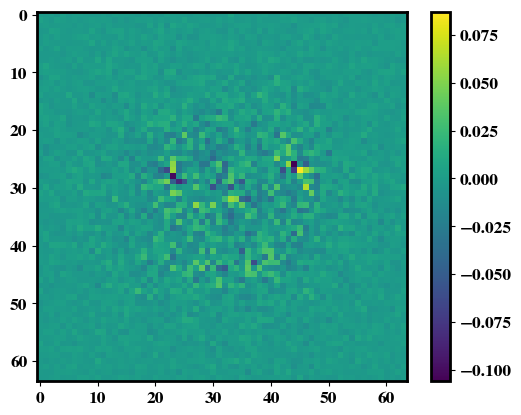

In [79]:
plt.close('all')
plt.imshow(noise_map.squeeze())
plt.colorbar()
plt.show()

## Compute SNR with lens light

In [140]:
n_rows = 3
n_cols = 8
n_img = n_rows*n_cols

plt.close('all')
#imgs = []
#for img_file in img_files[:n_img]:
#    img_path = os.path.join(baobab_cfg.out_dir, img_file)
#    imgs.append(np.load(img_path))

fig = plt.figure(figsize=(32, 12))
imgs_per_row = n_img//n_rows
#imgs = imgs[:imgs_per_row]*4
ax = []

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = 1#np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
print(noise_kwargs_default)
# Factor of effective exptime relative to exptime of the noiseless images
print(train_val_cfg.data.eff_exposure_time[bp])
noise_kwargs_default.update(exposure_time=5400.0)
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs_default)

orig_img_ids = np.arange(200)
#orig_img_ids = [43, 4]
distinct_lenses = len(orig_img_ids)
#img_ids = orig_img_ids*4

snr_dict = {} # will be populated as a nested dict, img[img_id][exp_factor]
snr_summary_dict = {}
for exp_i, exp_factor in enumerate([0.5, 1.0, 2.0]):
    snr_dict[exp_factor] = []
    for i, img_id in enumerate(orig_img_ids):
        noise_kwargs_default.update(exposure_time=5400*exp_factor)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        img = np.load(os.path.join(baobab_cfg.out_dir, 'X_{0:07d}.npy'.format(img_id)))
        img *= exp_factor
        noise_map = np.abs(noise_model.get_noise_map(img))
        img += noise_map
        snr = np.median(img/noise_map)
        snr_dict[exp_factor].append(snr)
    snr_summary_dict[exp_factor] = np.median(snr_dict[exp_factor])
    print(snr_summary_dict[exp_factor])

{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
10800.0
34.63099453390605
73.38002455325673
154.19148485192653


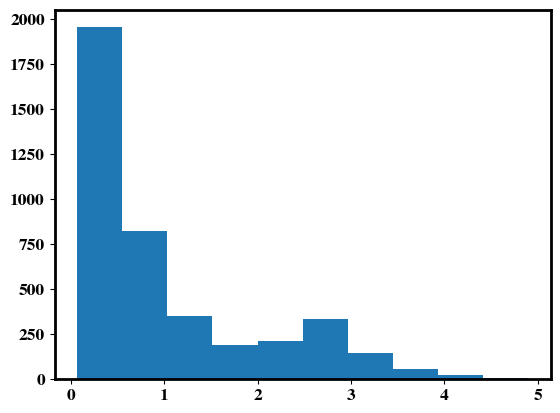

In [61]:
plt.hist(img.flatten())
plt.show()

## Compute SNR without lens light (excluding lens light from signal)

In [208]:
bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = 1#np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
noise_kwargs_default.update(exposure_time=5400.0)
print(noise_kwargs_default)

lens_mass_model = LensModel(lens_model_list=['PEMD', 'SHEAR_GAMMA_PSI'])
src_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
lens_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
components = ['lens_mass', 'src_light', 'agn_light', ] 

snr_dict_no_lens = {} # will be populated as a nested dict, img[img_id][exp_factor]
snr_summary_dict_no_lens = {}
for exp_i, exp_factor in enumerate([0.5, 1.0, 2.0]):
    snr_dict_no_lens[exp_factor] = []
    for i, lens_i in enumerate(np.arange(200)):
        noise_kwargs_default.update(exposure_time=5400*exp_factor)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        
        imager = Imager(components, lens_mass_model, src_light_model, lens_light_model=lens_light_model, ps_model=ps_model, kwargs_numerics={'supersampling_factor': 1}, min_magnification=0.0, for_cosmography=True)
        imager._set_sim_api(num_pix=64, kwargs_detector=noise_kwargs_default, psf_kernel_size=99, which_psf_maps=[101])
        imager.kwargs_src_light = [metadata_utils.get_kwargs_src_light(metadata.iloc[lens_i])]
        imager.kwargs_src_light = flux_utils.mag_to_amp_extended(imager.kwargs_src_light, imager.src_light_model, imager.data_api)
        imager.kwargs_lens_mass = metadata_utils.get_kwargs_lens_mass(metadata.iloc[lens_i])
        sample_ps = [metadata_utils.get_kwargs_ps_lensed(metadata.iloc[lens_i])]
        imager.for_cosmography = False
        imager._load_agn_light_kwargs(metadata_utils.get_nested_ps(metadata.iloc[lens_i]))
        lensed_total_flux, img = flux_utils.get_lensed_total_flux(imager.kwargs_lens_mass, imager.kwargs_src_light, None, imager.image_model, return_image=True)
        lensed_ring_total_flux = np.sum(img)
        img *= exp_factor
        noise_map = np.abs(noise_model.get_noise_map(img))
        img += noise_map
        #print("Sum of noise: ", np.sum(noise_map))
        if False:
            print(np.sum(noise_map))
            plt.imshow(img)
            plt.colorbar()
            plt.show()
        snr_no_lens_per_pixel = np.median(img/noise_map)
        snr_no_lens = np.sum(img)/np.sum(noise_map)
        snr_dict_no_lens[exp_factor].append((snr_no_lens_per_pixel, snr_no_lens))
    snr_summary_dict_no_lens[exp_factor] = (np.median(snr_dict_no_lens[exp_factor][0]), np.median(snr_dict_no_lens[exp_factor][1]))
    print(snr_summary_dict_no_lens[exp_factor])


{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
(6.654231470485542, 4.511979155356323)
(16.01307462727918, 10.268616113843029)
(37.71569653402311, 23.889467040095113)


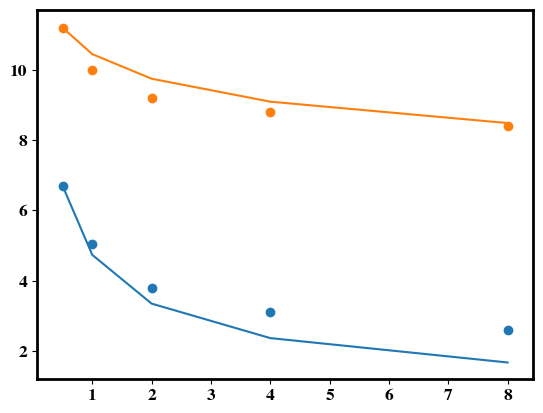

In [199]:
exp_grid = np.array([0.5, 1, 2, 4, 8])
noise_sum = np.array([6.7, 5.05, 3.8, 3.1, 2.6])
noise_sum2 = np.array([11.2, 10.0, 9.2, 8.8, 8.4])
plt.scatter(exp_grid, noise_sum)
plt.scatter(exp_grid, noise_sum2)
plt.plot(exp_grid, noise_sum[0]/(exp_grid/0.5)**0.5)
plt.plot(exp_grid, noise_sum2[0]/(exp_grid/0.5)**0.1)
plt.show()

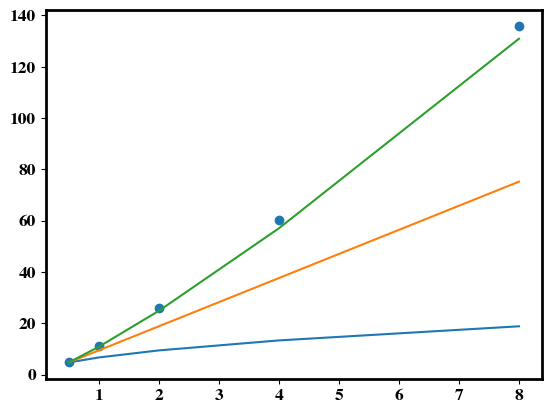

In [206]:
exp_grid = np.array([0.5, 1, 2, 4, 8])
snr_sum = np.array([4.7, 11, 26, 60.2, 135.7])
plt.scatter(exp_grid, snr_sum)
plt.plot(exp_grid, snr_sum[0]*(exp_grid/exp_grid[0])**0.5)
plt.plot(exp_grid, snr_sum[0]*(exp_grid/exp_grid[0]))
plt.plot(exp_grid, snr_sum[0]*(exp_grid/exp_grid[0])**1.2)
plt.show()

Transformed
(353200,)
7.837374533347596


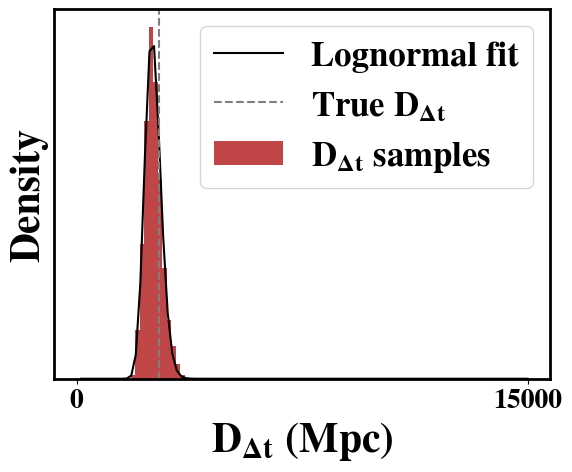

In [62]:
from h0rton.h0_inference import plotting_utils, h0_utils
plt.close('all')
# Plot a D_dt histogram for the pipeline diagram
saved_dict = np.load('/home/jwp/stage/sl/h0rton/experiments/v3/mcmc_default/D_dt_dict_0005.npy', allow_pickle=True).item()
uncorrected_D_dt_samples = saved_dict['D_dt_samples']
oversampling = 20
uncorrected_D_dt_samples = h0_utils.remove_outliers_from_lognormal(uncorrected_D_dt_samples, 3).reshape(-1, 1) # [n_samples, 1] 
k_ext_rv = getattr(stats, test_cfg.kappa_ext_prior.dist)(**test_cfg.kappa_ext_prior.kwargs)
k_ext = k_ext_rv.rvs(size=[len(uncorrected_D_dt_samples), oversampling]) # [n_samples, oversampling]
if test_cfg.kappa_ext_prior.transformed:
    print("Transformed")
    D_dt_samples = (uncorrected_D_dt_samples*k_ext).flatten()
    print(D_dt_samples.shape)
else:
    D_dt_samples = (uncorrected_D_dt_samples/(1.0 - k_ext)).flatten() # [n_samples,]

D_dt_stats = h0_utils.get_lognormal_stats(D_dt_samples)
print(D_dt_stats['mu'])
D_dt_grid = np.linspace(0, 15000, 100)
plt.plot(D_dt_grid, plotting_utils.lognormal(D_dt_grid, D_dt_stats['mu'], D_dt_stats['sigma']), color='k', label='Lognormal fit')
plt.hist(D_dt_samples, range=[0, 15000], bins=100, color='#c04546', density=True, label='$D_{\Delta t}$ samples')
plt.axvline(saved_dict['true_D_dt'], c='tab:gray', ls='--', label='True $D_{\Delta t}$')
plt.legend(fontsize=25)
plt.xlabel('$D_{\Delta t}$ (Mpc)', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.xticks([0, 15000], [0, 15000], fontsize=20)
plt.yticks([], [])
plt.show()

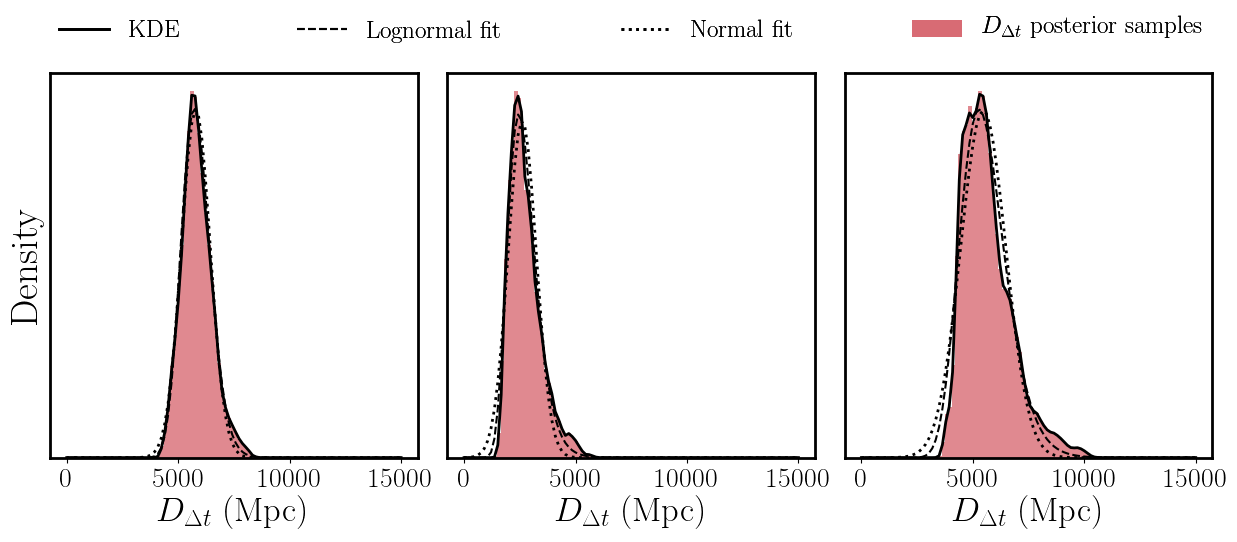

In [31]:
from h0rton.h0_inference import plotting_utils, h0_utils
from scipy.stats import norm, gaussian_kde
plt.close('all')
# Plot a D_dt histogram for the pipeline diagram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, lens_i in enumerate([ 20, 169, 31,]):
    saved_dict = np.load('/home/jwp/stage/sl/h0rton/experiments/v2/mcmc_default/D_dt_dict_{0:04}.npy'.format(lens_i), allow_pickle=True).item()
    uncorrected_D_dt_samples = saved_dict['D_dt_samples']
    oversampling = 20
    uncorrected_D_dt_samples = h0_utils.remove_outliers_from_lognormal(uncorrected_D_dt_samples, 3).reshape(-1, 1) # [n_samples, 1] 
    k_ext_rv = getattr(stats, test_cfg.kappa_ext_prior.dist)(**test_cfg.kappa_ext_prior.kwargs)
    k_ext = k_ext_rv.rvs(size=[len(uncorrected_D_dt_samples), oversampling]) # [n_samples, oversampling]
    if test_cfg.kappa_ext_prior.transformed:
        #print("Transformed")
        D_dt_samples = (uncorrected_D_dt_samples*k_ext).flatten()
        #print(D_dt_samples.shape)
    else:
        D_dt_samples = (uncorrected_D_dt_samples/(1.0 - k_ext)).flatten() # [n_samples,]
        
    D_dt_grid = np.linspace(0, 15000, 100)
    # Plot KDE
    kde = gaussian_kde(D_dt_samples, bw_method='scott')
    axes[i].plot(D_dt_grid, kde(D_dt_grid), color='k', linestyle='solid', label='KDE', linewidth=2)
    # Plot lognormal fit
    D_dt_stats = h0_utils.get_lognormal_stats(D_dt_samples)
    axes[i].plot(D_dt_grid, plotting_utils.lognormal(D_dt_grid, D_dt_stats['mu'], D_dt_stats['sigma']), color='k', linestyle='dashed', label='Lognormal fit')
    # Plot normal fit
    D_dt_stats_normal = h0_utils.get_normal_stats(D_dt_samples)
    axes[i].plot(D_dt_grid, norm.pdf(D_dt_grid, loc=D_dt_stats_normal['mean'], scale=D_dt_stats_normal['std']), color='k', ls='dotted', label='Normal fit', linewidth=2)
    # Plot samples
    axes[i].hist(D_dt_samples, range=[0, 15000], bins=100, color='#d6616b', density=True, label='$D_{\Delta t}$ posterior samples', alpha=0.75)
    #plt.axvline(saved_dict['true_D_dt'], c='tab:gray', ls='--', label='True $D_{\Delta t}$')
    axes[i].set_yticks([])
    axes[i].set_xlabel('$D_{\Delta t}$ (Mpc)', fontsize=25)
    #axes[i].set_ylabel('Density', fontsize=25)
    #plt.xticks([0, 15000], [0, 15000], fontsize=20)
global_legend = axes[0].legend(bbox_to_anchor=(0.03, 1.03, 2 + 1.1, 0.102), loc='upper center', ncol=4, mode="expand", borderaxespad=-0.5, fontsize=18, frameon=False, columnspacing=0.08)

axes[0].add_artist(global_legend)
axes[0].set_ylabel('Density', fontsize=28)
plt.subplots_adjust(wspace=0.08)

plt.show()
fig.savefig('../kde_vs_lognormal_vs_normal.png', bbox_inches='tight', pad_inches=0)

{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
21600.0
0.007969365501346347 2.9090085289696175 2.9010391634682713
-0.6687418182550386 6.677613496727318 7.346355314982357
0.023976064144390203 3.5725896640787616 3.5486135999343715
-0.7674006283872836 5.817245584602148 6.584646212989432
0.04404694444317785 4.254301905355585 4.210254960912407
-0.9070190950401243 5.143599747923554 6.0506188429636785
0.08616342165223952 4.940381446906093 4.854218025253854
-1.0726190735715861 4.633321525566537 5.705940599138124


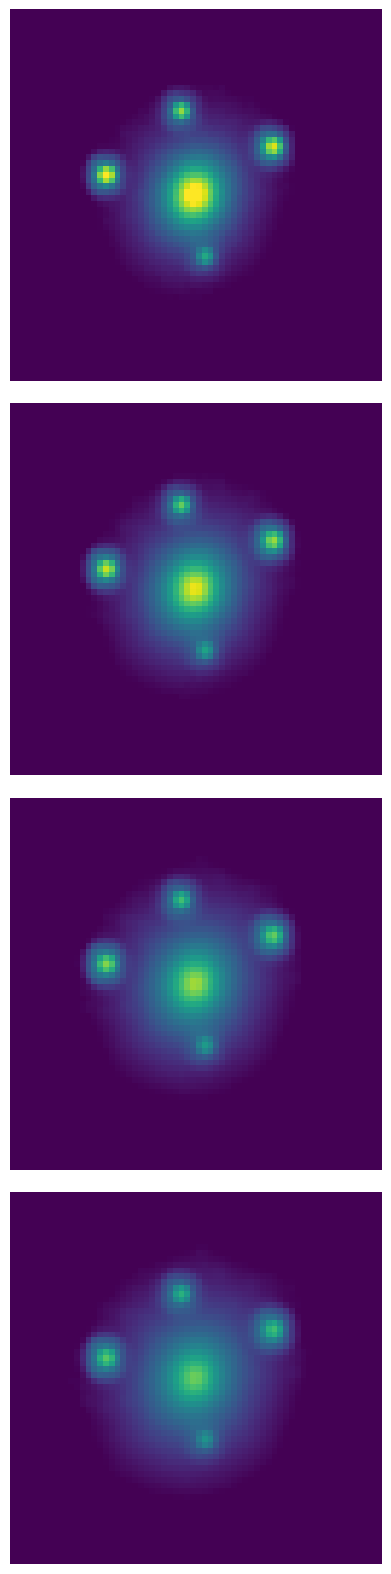

In [136]:
n_rows = 4
n_cols = 1
n_img = n_rows*n_cols

plt.close('all')
#imgs = []
#for img_file in img_files[:n_img]:
#    img_path = os.path.join(baobab_cfg.out_dir, img_file)
#    imgs.append(np.load(img_path))

fig = plt.figure(figsize=(32, 16))
imgs_per_row = n_img//n_rows
#imgs = imgs[:imgs_per_row]*4
ax = []

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
print(noise_kwargs_default)
# Factor of effective exptime relative to exptime of the noiseless images
print(train_val_cfg.data.eff_exposure_time[bp])
noise_kwargs_default.update(exposure_time=5400.0)
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs_default)

orig_img_ids = [43, 4, 39, 69, 58, 56, 70, 63][::-1]
#orig_img_ids = [43, 4]
distinct_lenses = len(orig_img_ids)
#img_ids = orig_img_ids*4

for i in range(n_cols*n_rows):
    img_id = orig_img_ids[i%n_cols]
    #print(np.min(img), np.max(img))
    if i//n_cols == 0:
        exposure_time_factor[0, :, :] = 0.5
        noise_kwargs_default.update(exposure_time=5400*0.5)
    elif i//n_cols == 1:
        exposure_time_factor[0, :, :] = 1
        noise_kwargs_default.update(exposure_time=5400*1)
    elif i//n_cols == 2:
        exposure_time_factor[0, :, :] = 2
        noise_kwargs_default.update(exposure_time=5400*2)
    else:
        exposure_time_factor[0, :, :] = 4
        noise_kwargs_default.update(exposure_time=5400*4)
    img = np.load(os.path.join(baobab_cfg.out_dir, 'X_{0:07d}.npy'.format(img_id)))
    noise_model = NoiseModelNumpy(**noise_kwargs_default)
    #print(noise_model.exposure_time_tot)
    
    #plt.subplot(n_rows, n_cols, i+1)
    img *= exposure_time_factor
    #print(exposure_time_factor[0, 0, 0], np.min(img), np.max(img))
    noise_map = noise_model.get_noise_map(img)
    #print(img_id, i // n_cols, noise_map[0, :5, 0])
    img += noise_map
    img = np.log1p(img)
    print(np.min(img), np.max(img), np.max(img) - np.min(img))
    img = (img - img.mean())/img.std()
    img = np.squeeze(img)
    print(np.min(img), np.max(img), np.max(img) - np.min(img))
    # create subplot and append to ax
    fig.add_subplot(n_rows, n_cols, i+1)
    #print(exposure_time_factor[0, 0, 0], np.min(img), np.max(img))
    #plt.imshow(img, origin='lower', vmin=0, vmax=5, cmap='viridis', norm=None)
    plt.imshow(img, origin='lower', vmin=0, vmax=6, cmap='viridis', norm=None)
    plt.axis('off')
plt.tight_layout()
#plt.savefig('../training_set_gallery.png')
plt.show()